# Application My Credit

>> Descriptions détaillées des colonnes données clients bancaires :

* 1 - 'age' : (numérique)

* 2 - 'job' : type d'emploi (catégorique : "admin.", "inconnu", "chômeur", "gestion", "femme de ménage", "entrepreneur", "étudiant", "col bleu", "indépendant", "retraité", "technicien", "services")

* 3 - 'marital' : état civil (catégorique : "marié", "divorcé", "célibataire" ; attention : "divorcé" signifie divorcé ou veuf)

* 4 - 'education' : (catégorique : "inconnu", "secondaire", "primaire", "tertiaire")

* 5 - 'default' : le crédit est-il en défaut ? (binaire : "oui", "non")

* 6 - 'balance' : solde annuel moyen, en euros (numérique) 

* 7 - 'housing' : a-t-il un prêt logement ? (binaire : "oui", "non")

* 8 - 'loan' : avez-vous un prêt personnel ? (binaire : "oui", "non")

>> lié au dernier contact de la campagne en cours :

* 9 - 'contact' : type de communication du contact (catégorique : "inconnu", "téléphone", "cellulaire")

* 10 - 'day' : dernier jour de contact du mois (numérique)

* 11 - 'month' : dernier mois de contact de l'année (catégorique : "jan" , "feb", "mar", …, "nov", "dec")

* 12 - 'duration' : durée du dernier contact, en secondes (numérique)

>> autres attributs :

* 13 - 'campaign' : nombre de contacts effectués pendant cette campagne et pour ce client (numérique, inclut le dernier contact)

* 14 - 'pdays' : nombre de jours écoulés après que le client a été contacté pour la dernière fois lors d'une campagne précédente (numérique, -1 signifie que le client n'a pas été contacté auparavant)

* 15 - 'previous' : nombre de contacts effectués avant cette campagne et pour ce client (numérique)

* 16 - 'poutcome' : résultat de la campagne marketing précédente (catégorique : "inconnu", "autre", "échec", "succès")

>> Variable de sortie (cible souhaitée) :

* 17 - 'y' : le client a-t-il obtenu un crédit ? (binaire : "oui", "non")

## Import des librairies nécessaires au projet

In [9]:
# packages import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import json
import pickle
import os

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Découverte des datasets 'train' et 'test'

In [2]:
# afficher le dataset 'train'
df_train = pd.read_csv('train.csv', delimiter=';')

df_train.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [3]:
# afficher le dataset 'test'
df_test = pd.read_csv('test.csv', delimiter=';')

df_test.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [4]:
# affichage des informations globales pour le 'train'
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# affichage des informations globales pour le 'test'
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


Pas de valeurs manquantes.

In [6]:
# pour la colonne target 'y', affichage du nombre de 'no' & 'yes'
df_train['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

### Création d'une fonction permettant d'encoder les valeurs "texte" du df

In [10]:
# fonction d'encodage et de sauvegarde des encodeurs en JSON
def le_df_and_save_json(df):
  """
  Fonction qui encode les caractères catégoriels d'un DataFrame et sauvegarde les correspondances dans un fichier JSON.
  """
  df_copy = df.copy()
  # Encodeur
  le = LabelEncoder()
  # Dictionnaire ou l'on sauvegarde l'encodage
  encode_dict = {}
  # Liste de colonnes catégorielles
  cat_col_list = list(df_copy.select_dtypes(include=['object']).columns)
  

  for col in cat_col_list: 
    df_copy[col] = le.fit_transform(df_copy[col])
    encode_dict[col] = {le.classes_[i]:i for i in range(len(le.classes_))}
  
  # Si le fichier n'existe pas alors : 
  if not os.path.exists('encode_dict.json'):
    with open(f"encode_dict.json", 'w') as fp:
      json.dump(encode_dict, fp)
  
  return df_copy, encode_dict

In [11]:
# Passage des dfs à la fonction d'encodage
df_train_encoded, encode_dict_train = le_df_and_save_json(df_train)
df_test_encoded, encode_dict_test = le_df_and_save_json(df_test)

In [13]:
# affichage du 'df_test' encodé
df_test_encoded.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0
5,35,4,2,2,0,747,0,0,0,23,3,141,2,176,3,0,0
6,36,6,1,2,0,307,1,0,0,14,8,341,1,330,2,1,0
7,39,9,1,1,0,147,1,0,0,6,8,151,2,-1,0,3,0
8,41,2,1,2,0,221,1,0,2,14,8,57,2,-1,0,3,0
9,43,7,1,0,0,-88,1,1,0,17,0,313,1,147,2,0,0


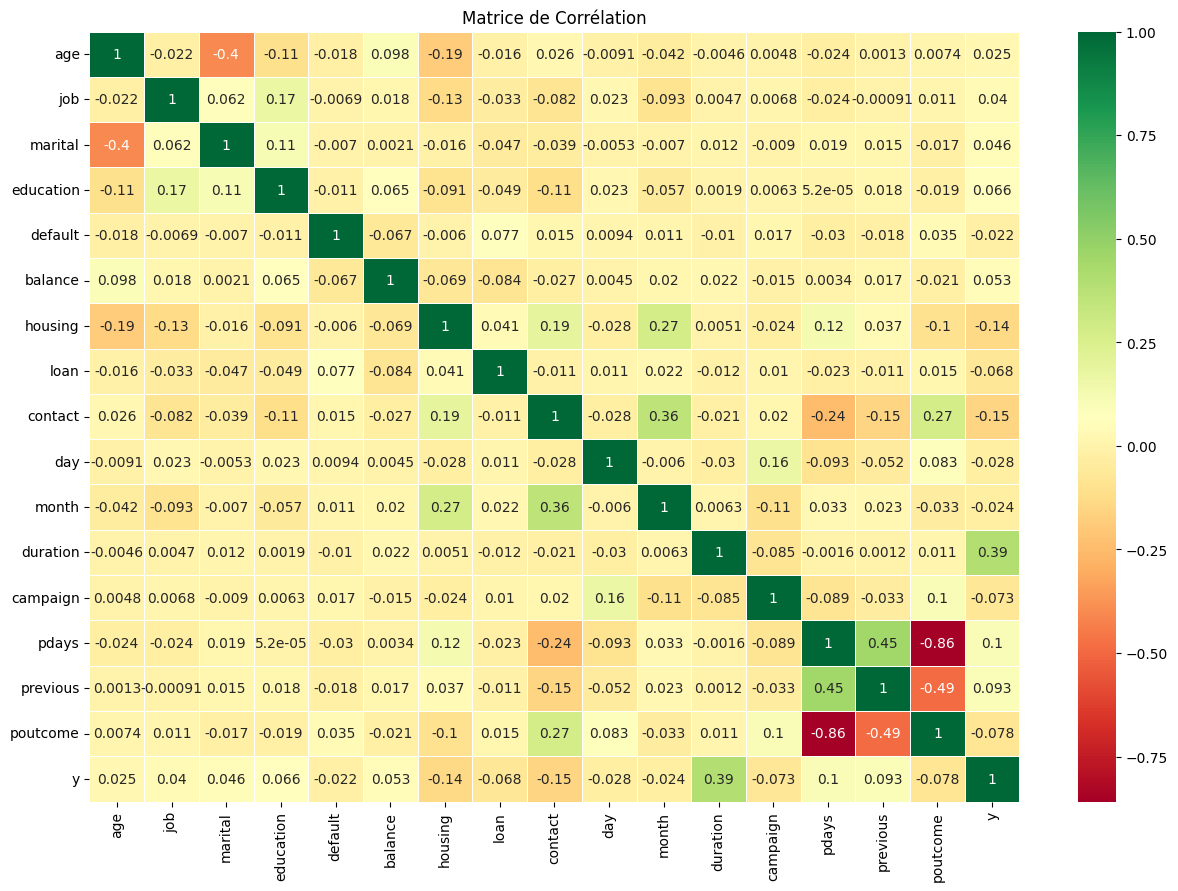

In [14]:
# affichage d'une matrice de corrélation
correlation_matrix = df_train_encoded.corr()

plt.figure(figsize=(15, 10))  # Définir la taille de la figure
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

On voit que la feature 'poutcome' est fortement corrélée avec 'pdays' et aussi, à une moindre mesure, corrélée à la feature 'previous', on va donc supprimer cette colonne des dfs 'train' & 'test'.

In [15]:
# suppression de la colonne 'poutcome' dans les deux dfs
df_train_encoded.drop("poutcome", axis=1, inplace=True)
df_test_encoded.drop("poutcome", axis=1, inplace=True)

# affichage du df 'train' encodé après modification
df_train_encoded.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,0
5,35,4,1,2,0,231,1,0,2,5,8,139,1,-1,0,0
6,28,4,2,2,0,447,1,1,2,5,8,217,1,-1,0,0
7,42,2,0,2,1,2,1,0,2,5,8,380,1,-1,0,0
8,58,5,1,0,0,121,1,0,2,5,8,50,1,-1,0,0
9,43,9,2,1,0,593,1,0,2,5,8,55,1,-1,0,0


In [16]:
# affichage des valeurs de la colonne 'pdays'
df_train_encoded["pdays"].value_counts()

pdays
-1      36954
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: count, Length: 559, dtype: int64

On remarque qu'une majorité des clients ont pour valeur '-1' ce qui signifie qu'ils n'ont pas été recontacté suite à la campagne marketing et le reste des valeurs correspondent au nombre de fois où ils ont été contactés. Il est plus intéressant de transformer cette colonne en deux catégories : non-contacté, contacté

In [17]:
# fonction permettant la modification de la colonne 'pdays', 0 = client non-contacté & 1 = client contacté
def transform_pdays_column(df):
    df['pdays'] = df['pdays'].apply(lambda x: 0 if x == -1 else 1)
    return df

# application de la fonction aux dfs 'train' & 'test'
df_train_final = transform_pdays_column(df_train_encoded)
df_test_final = transform_pdays_column(df_test_encoded)

In [18]:
# affichage du df 'test' final
df_test_final.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,0,0,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,1,4,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,1,1,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,0,0,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,0,0,0
5,35,4,2,2,0,747,0,0,0,23,3,141,2,1,3,0
6,36,6,1,2,0,307,1,0,0,14,8,341,1,1,2,0
7,39,9,1,1,0,147,1,0,0,6,8,151,2,0,0,0
8,41,2,1,2,0,221,1,0,2,14,8,57,2,0,0,0
9,43,7,1,0,0,-88,1,1,0,17,0,313,1,1,2,0


## Machine Learning

### XGBoost Classifier

In [19]:
# split du 'train' & 'test'
X_train_XGBC = df_train_final.drop("y", axis=1)
y_train_XGBC = df_train_final["y"]

X_test_XGBC = df_test_final.drop("y", axis=1)
y_test_XGBC = df_test_final["y"]

In [20]:
# standardisation des valeurs
scaler = StandardScaler()
X_train_XGBC_scaled = scaler.fit_transform(X_train_XGBC)
X_test_XGBC_scaled = scaler.transform(X_test_XGBC)

In [21]:
# création & entraînement du modèle
model_XGBC = xgb.XGBClassifier()
model_XGBC.fit(X_train_XGBC_scaled, y_train_XGBC)

c:\Users\utilisateur\Documents\GitHub\My-Credit\.credenv\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
# enregistrement des prédictions
y_pred_XGBC = model_XGBC.predict(X_test_XGBC_scaled)

Accuracy score with LogisticRegression: 94.62508294625083 %
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      4000
           1       0.81      0.70      0.75       521

    accuracy                           0.95      4521
   macro avg       0.89      0.84      0.86      4521
weighted avg       0.94      0.95      0.94      4521



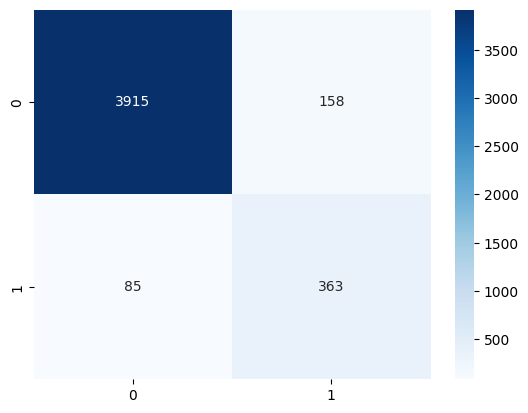

In [23]:
# affichage des résultats et d'une matrice de confusion
acc_xgbc = accuracy_score(y_pred_XGBC, y_test_XGBC)
cm_xgbc = confusion_matrix(y_pred_XGBC, y_test_XGBC)
class_report_XGBC = classification_report(y_test_XGBC, y_pred_XGBC)
sns.heatmap(cm_xgbc, annot=True, cmap='Blues', fmt='g')
print(f"Accuracy score with LogisticRegression:", acc_xgbc*100,"%")
print("Classification Report:\n", class_report_XGBC)

## Analyse de l'importance des features

In [24]:
# Obtenir les importances des caractéristiques
feature_importance = model_XGBC.get_booster().get_score(importance_type='weight')

# Créer un dictionnaire pour stocker les noms des caractéristiques et leurs scores
feature_importance_dict = {}

# Parcourir le dictionnaire d'importance des caractéristiques
for feature, importance in feature_importance.items():
    # Trouver le nom de la colonne correspondant à l'indice (feature)
    column_name = X_train_XGBC.columns[int(feature.split('f')[1])]
    feature_importance_dict[column_name] = importance

# Trier le dictionnaire par ordre décroissant d'importance
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

feature_importance_dict_sorted = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
feature_importance_dict_sorted

[('duration', 761.0),
 ('balance', 736.0),
 ('age', 602.0),
 ('day', 593.0),
 ('month', 508.0),
 ('job', 240.0),
 ('campaign', 219.0),
 ('education', 129.0),
 ('previous', 119.0),
 ('housing', 104.0),
 ('marital', 100.0),
 ('contact', 92.0),
 ('pdays', 72.0),
 ('loan', 43.0),
 ('default', 16.0)]

## Export

In [25]:
# export des noms et types des colonnes
def get_col_names_and_types(df):
    """Cette fonction permet d'extraire les noms des colonnes et leur type, et des les enregistrer dans une liste."""
    # Get the data types of the DataFrame columns
    column_types = df.dtypes

    # Create a dictionary from the column names and data types
    col_type_dict = dict(zip(df.columns, column_types))

    return col_type_dict

 
col_type_dict = get_col_names_and_types(df_train.drop(['poutcome', 'y'], axis=1))
col_type_dict

{'age': dtype('int64'),
 'job': dtype('O'),
 'marital': dtype('O'),
 'education': dtype('O'),
 'default': dtype('O'),
 'balance': dtype('int64'),
 'housing': dtype('O'),
 'loan': dtype('O'),
 'contact': dtype('O'),
 'day': dtype('int64'),
 'month': dtype('O'),
 'duration': dtype('int64'),
 'campaign': dtype('int64'),
 'pdays': dtype('int64'),
 'previous': dtype('int64')}

In [26]:
# création du dictionnaire pour le stockage des objets
pickle_dict = {

    "columns" : col_type_dict,

    "scaler" : scaler,

    "model" : model_XGBC,

    "feature_importance" : feature_importance_dict_sorted

}

In [ ]:
# export des objets dans un fichier pickle
with open('modele_data.pkl', 'wb') as file:
    pickle.dump(pickle_dict, file)